In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

## For kfold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [515]:
train_dataframe = pd.read_csv('../data/train_processed.csv')
X,y = train_dataframe.drop('y', axis=1), train_dataframe['y']


In [516]:
## Check for multi collinearity in X
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)


,VIF Factor,features
0,6.500000e+00,x7_Hambo
1,2.200000e+00,x7_Polka
2,4.500000e+00,x7_Polskor
3,3.600000e+00,x7_Schottis
4,2.500000e+00,x7_Slängpolskor
5,1.000000e+00,x12_True
6,1.135252e+11,x1
7,3.200000e+00,x2
8,1.271056e+10,x3
9,2.210000e+01,x4


In [197]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit and XGBoost model
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
# xgb.fit(X_train, y_train)

## Get the confusion matrix
# y_pred = xgb.predict(X_test)
# display(pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues'))

## Set a k-fold cross validation test to get the accuracy

kf = KFold(n_splits=5, shuffle=True, random_state=56)
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # clf = CatBoostClassifier(max_depth=5, verbose=False)
    xgb = CatBoostClassifier(verbose=False)
    # xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
    xgb.fit(X_train, y_train)

    
    print("Train Accuracy:", accuracy_score(y_train, xgb.predict(X_train)))
    print("Test Accuracy:", accuracy_score(y_test, xgb.predict(X_test)))

    acc.append(accuracy_score(y_test, xgb.predict(X_test)))

    ## Plot the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    display(pd.DataFrame(confusion_matrix(y_test, xgb.predict(X_test))).style.background_gradient(cmap='Blues'))

    print()


Train Accuracy: 1.0
Test Accuracy: 0.7878787878787878


,0,1,2
0,28,1,11
1,0,37,17
2,2,11,91



Train Accuracy: 1.0
Test Accuracy: 0.7525252525252525


,0,1,2
0,26,4,7
1,1,40,14
2,6,17,83



Train Accuracy: 1.0
Test Accuracy: 0.7309644670050761


,0,1,2
0,33,1,9
1,0,45,22
2,5,16,66



Train Accuracy: 1.0
Test Accuracy: 0.766497461928934


,0,1,2
0,23,1,10
1,2,32,21
2,3,9,96



Train Accuracy: 1.0
Test Accuracy: 0.7360406091370558


,0,1,2
0,17,3,11
1,0,27,23
2,6,9,101


In [199]:
print(f'Average accuracy: {np.mean(acc)}')

Average accuracy: 0.7547813156950213


## Model Explanation

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

## Fit and XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
# xgb = CatBoostClassifier(verbose=False)
xgb.fit(X_train, y_train)

## Get the confusion matrix
y_pred = xgb.predict(X_test)
display(pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues'))

## Get the accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

,0,1,2
0,35,1,8
1,1,37,24
2,4,14,74


Accuracy score: 0.7373737373737373


In [215]:
## Shap Analysis 
import shap

explainer = shap.Explainer(xgb.predict, X_test, feature_names=X_test.columns)
maxp_values = explainer(X_test,max_evals=800)

Permutation explainer: 199it [00:34,  4.17it/s]                         


In [216]:
shap.initjs()
shap.force_plot(maxp_values.base_values[:],maxp_values.values[:],features=X_test[:],feature_names=X_test.columns)

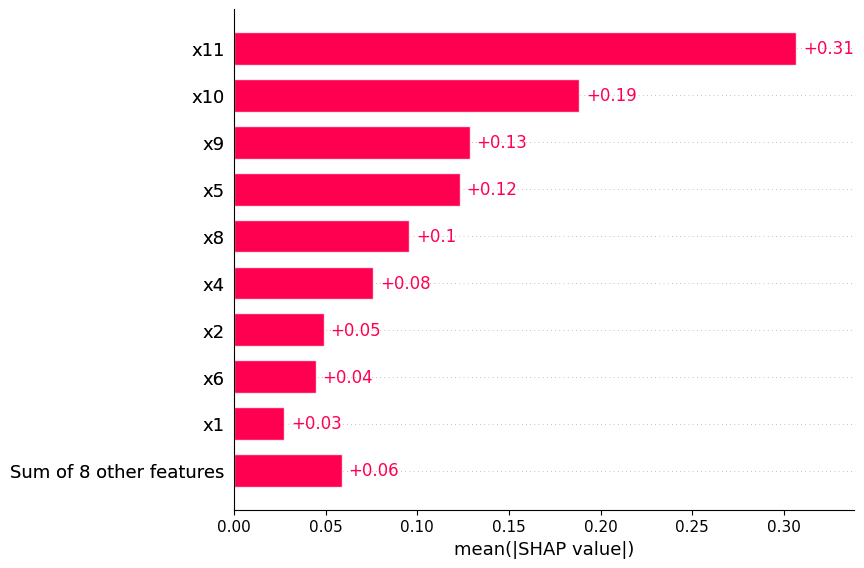

In [224]:
shap.plots.bar(maxp_values)


## OVR on 2

[09:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


,0,1
0,161,77
1,46,210


0.7510121457489879
0.7483915441176471


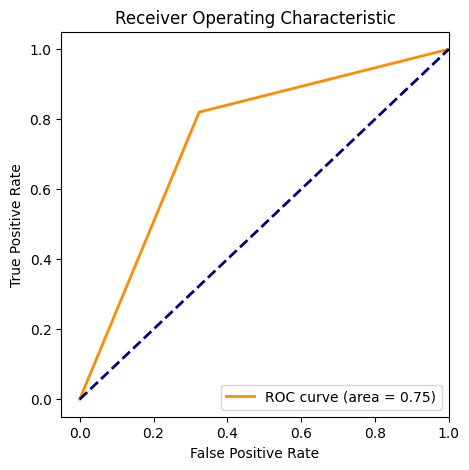

In [181]:
## Predicting OVR on 2
X,y = train_dataframe.drop('y', axis=1), train_dataframe['y']
y = (y == 2).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Fit and XGBoost model and check the conf matrix
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
display(pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues'))

## Calculate the accuracy score and ROC AUC score
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

## Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [182]:
## Shap Analysis 
import shap

explainer = shap.Explainer(xgb.predict, X_test, feature_names=X_test.columns)
maxp_values = explainer(X_test,max_evals=800)


Permutation explainer: 495it [01:00,  6.90it/s]                         


In [183]:
shap.initjs()
shap.force_plot(maxp_values.base_values[:],maxp_values.values[:],features=X_test[:],feature_names=X_test.columns)

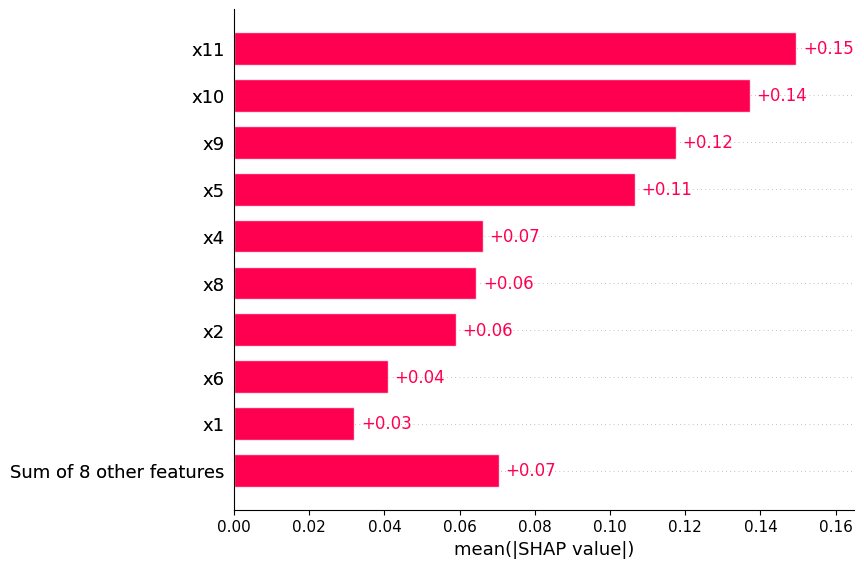

In [184]:
shap.plots.bar(maxp_values)


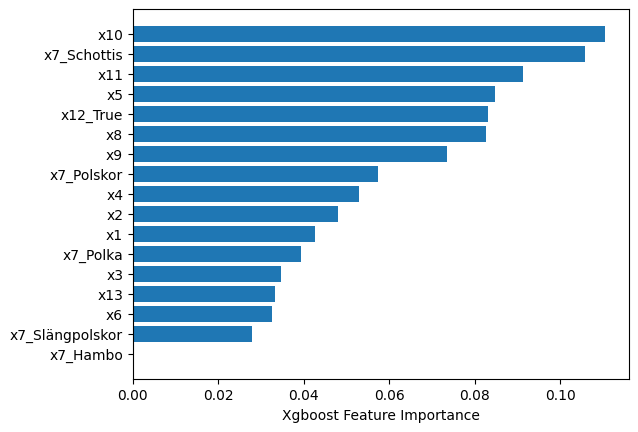

In [185]:
## Sort features by importance
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [42]:
## Testing SHAP on the wrong predictions

## Get all X_wrong and y_wrong values from the test set
X_wrong = X_test[y_test != y_pred]
y_wrong = y_test[y_test != y_pred]

## Get the shap values for the wrong predictions
explainer = shap.Explainer(xgb.predict, X_wrong, feature_names=X_wrong.columns)
maxp_values = explainer(X_wrong,max_evals=800)

## Plot the shap values
shap.initjs()
shap.force_plot(maxp_values.base_values[:],maxp_values.values[:],features=X_wrong[:],feature_names=X_wrong.columns)

Permutation explainer: 124it [00:13,  2.47it/s]                         


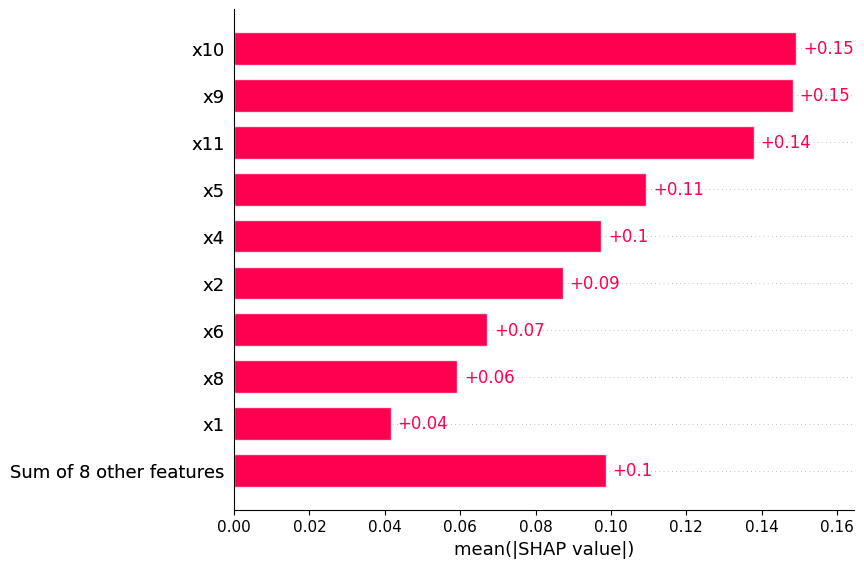

In [43]:
shap.plots.bar(maxp_values)


### Making Reduced Tree

0.7011144883485309


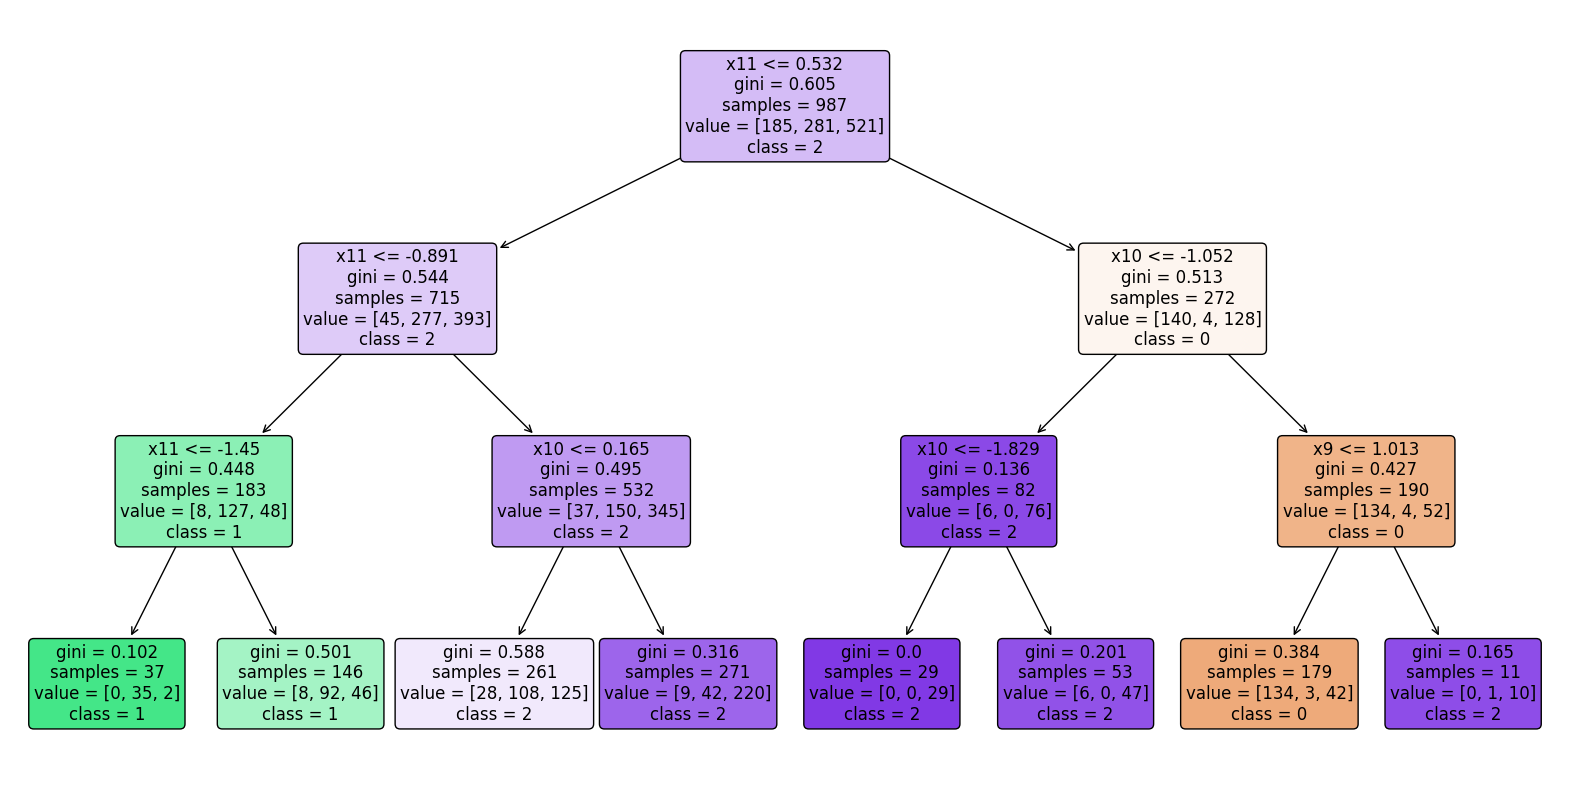

In [485]:
X,y = train_dataframe.drop(['y'], axis=1), train_dataframe['y']
X = X[['x10','x9','x11']]

## Make and plot a decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(max_depth=3, criterion='gini')
dt.fit(X,y)

## Print the accuracy score
print(accuracy_score(y, dt.predict(X)))

plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, filled=True, fontsize=12, rounded=True, class_names=['0','1','2'])
plt.show()


### Testing Reduced models

In [486]:
## Import PCA
from sklearn.decomposition import PCA

In [527]:
def merge_features(dataframe,features):
    ## PCA the features from the dataframe
    pca = PCA(n_components=1)
    pca.fit(dataframe[features])
    dataframe['+'.join(features)] = pca.transform(dataframe[features])

    ## Drop the original features
    dataframe.drop(features, axis=1, inplace=True)

    return dataframe


def feature_engineering(X):
    X = merge_features(X,['x1','x3','x13'])
    X = merge_features(X,['x2','x6'])
    X = merge_features(X,['x4','x5'])

    return X[['x10','x9','x11','x8','x1+x3+x13','x2+x6','x4+x5']]



In [528]:
train_dataframe.columns

Index(['x7_Hambo', 'x7_Polka', 'x7_Polskor', 'x7_Schottis', 'x7_Slängpolskor',
       'x12_True', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10',
       'x11', 'x13', 'y'],
      dtype='object')

In [536]:
## Remove X9 from the dataset
X,y = train_dataframe.drop(['y'], axis=1), train_dataframe['y']

# X = feature_engineering(X)

# X['x_62'] = X['x6'] * X['x2']
# X['x_131'] = X['x13'] * X['x1']
# X['x_45'] = X['x4'] * X['x5']
X = X[['x10','x9','x11','x5','x4','x8']]


In [537]:
# train_dataframe_test = train_dataframe.sample(frac=0.2, random_state=42)
# train_dataframe_train = train_dataframe.drop(train_dataframe_test.index)

# X_train, y_train = train_dataframe_train.drop(['y'], axis=1), train_dataframe_train['y']
# X_test, y_test = train_dataframe_test.drop(['y'], axis=1), train_dataframe_test['y']


# X_train = X_train[['x10','x9','x11','x5','x4','x8']]
# X_test = X_test[['x10','x9','x11','x5','x4','x8']]

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

## Fit and XGBoost model
xgb = CatBoostClassifier(verbose=False)
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
xgb.fit(X_train, y_train)

## Get the confusion matrix
y_pred = xgb.predict(X_test)
display(pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues'))

## Get the accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

,0,1,2
0,36,1,7
1,1,38,23
2,3,14,75


Accuracy score: 0.7525252525252525


In [532]:

kf = KFold(n_splits=5, shuffle=True, random_state=56)

acc = []
f1 = []

for train_index, test_index in kf.split(X_train):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    xgb = CatBoostClassifier(verbose=False)
    # xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
    xgb.fit(X_train, y_train)

    
    print("Train Accuracy:", accuracy_score(y_train, xgb.predict(X_train)))
    print("Test Accuracy:", accuracy_score(y_test, xgb.predict(X_test)))
    print("Test F1 Score:", f1_score(y_test, xgb.predict(X_test), average='weighted'))

    

    acc.append(accuracy_score(y_test, xgb.predict(X_test)))
    f1.append(f1_score(y_test, xgb.predict(X_test), average='weighted'))

    ## Plot the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    display(pd.DataFrame(confusion_matrix(y_test, xgb.predict(X_test))).style.background_gradient(cmap='Blues'))


    print()

Train Accuracy: 1.0
Test Accuracy: 0.7341772151898734
Test F1 Score: 0.7323776117126735


,0,1,2
0,22,3,7
1,1,30,16
2,5,10,64



Train Accuracy: 1.0
Test Accuracy: 0.7658227848101266
Test F1 Score: 0.7630206084259027


,0,1,2
0,25,1,4
1,0,29,19
2,3,10,67



Train Accuracy: 1.0
Test Accuracy: 0.7531645569620253
Test F1 Score: 0.7528794560346083


,0,1,2
0,26,2,7
1,1,32,14
2,4,11,61



Train Accuracy: 1.0
Test Accuracy: 0.7721518987341772
Test F1 Score: 0.769698653249863


,0,1,2
0,20,2,10
1,1,32,12
2,1,10,70



Train Accuracy: 1.0
Test Accuracy: 0.7388535031847133
Test F1 Score: 0.7350586255044853


,0,1,2
0,14,2,9
1,0,24,14
2,6,10,78


In [533]:
print(f'Average accuracy: {np.mean(acc)}')
print(f'Average f1 score: {np.mean(f1)}')

Average accuracy: 0.7528339917761832
Average f1 score: 0.7506069909855067


## Post Hoc Explanation

In [539]:
## Fit and XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')
# xgb = CatBoostClassifier(verbose=False)
xgb.fit(X_train, y_train)

## Get the confusion matrix
y_pred = xgb.predict(X_test)
display(pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues'))

## Get the accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

,0,1,2
0,35,1,8
1,2,39,21
2,4,14,74


Accuracy score: 0.7474747474747475


In [540]:
import shap
## Wrong predictions
X_wrong = X_test[y_test != y_pred]
explainer = shap.Explainer(xgb.predict, X_wrong, feature_names=X_wrong.columns)
maxp_values = explainer(X_wrong,max_evals=800)
shap.initjs()
shap.force_plot(maxp_values.base_values[:],maxp_values.values[:],features=X_wrong[:],feature_names=X_wrong.columns)

In [541]:
import shap
## Wrong predictions
X_right = X_test[y_test == y_pred]
explainer = shap.Explainer(xgb.predict, X_right, feature_names=X_right.columns)
maxp_values = explainer(X_right,max_evals=800)
shap.initjs()
shap.force_plot(maxp_values.base_values[:],maxp_values.values[:],features=X_right[:],feature_names=X_right.columns)